In [1]:
%load_ext autoreload
%autoreload 2

import crispr as cr
from crispr.class_sc import Omics

file_path = {"directory": "data/crispr-screening/HH06"}
col_sample_id = "orig.ident"
kws_harmony = {"plot_convergence": True,
               "random_state": 1618}
kws_umap = {"min_dist": 0.3}
kws_init = {"assay": None, "assay_protein": None, 
            "col_gene_symbols": "gene_symbols", 
            "col_cell_type": "majority_voting", 
            "col_sample_id": None,
            "col_condition": None, 
            "key_control": None, 
            "key_treatment": None}
kws_pp = {"kws_hvg": {"min_mean": 0.0125, "max_mean": 10, 
                      "min_disp": 0.5, "flavor": "cell_ranger"}, 
          "target_sum": 10000.0, "cell_filter_pmt": [0, 15], 
          "cell_filter_ngene": [200, None], "cell_filter_ncounts": [3, 40000], 
          "gene_filter_ncell": [3, None], "regress_out": None, 
          "kws_scale": "log", "kws_umap": kws_umap}
kws_cluster = {"method_cluster": "leiden", "kws_umap": kws_umap, 
               "kws_neighbors": None,  "resolution": 1,
               "kws_pca": {"n_comps": None, "use_highly_variable": True}, 
               "resolution": 0.5, "kws_cluster": {}}

# Single-Cell Omics Object Initialization

In [2]:
self = Omics(file_path, **kws_init)



<<< INITIALIZING CRISPR CLASS OBJECT >>>


<<< LOADING PROTOSPACER METADATA >>>


Cell Counts: Raw

19226


Gene Counts: Raw



 AnnData object with n_obs × n_vars = 19226 × 36601
    obs: 'num_features', 'feature_call', 'num_umis'
    var: 'gene_ids', 'feature_types'
    layers: 'counts'



col_gene_symbols='gene_symbols'
col_cell_type='majority_voting'
col_sample_id=np.nan
col_batch=np.nan
col_condition=np.nan
key_control=np.nan
key_treatment=np.nan


 AnnData object with n_obs × n_vars = 19226 × 36601
    obs: 'num_features', 'feature_call', 'num_umis'
    var: 'gene_ids', 'feature_types'
    layers: 'counts'


# Preprocessing

Perform normalization, filtering, QC, etc.

AnnData object with n_obs × n_vars = 19226 × 36601
    obs: 'num_features', 'feature_call', 'num_umis', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'
    layers: 'counts'

Un-Used Keyword Arguments: {'assay_protein': None, 'col_sample_id': None, 'col_batch': None, 'col_condition': None, 'kws_umap': {'min_dist': 0.3}}




Cell Counts: Initial

19226


Gene Counts: Initial

None 

 10 

                gene_ids    feature_types
count             36601            36601
unique            36601                1
top     ENSG00000243485  Gene Expression
freq                  1            36601 



<<< PERFORMING QUALITY CONTROL ANALYSIS>>>


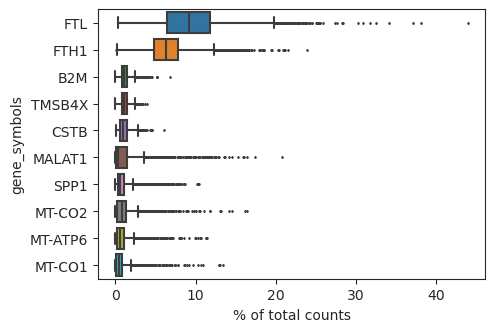


	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'feature_types' as categorical


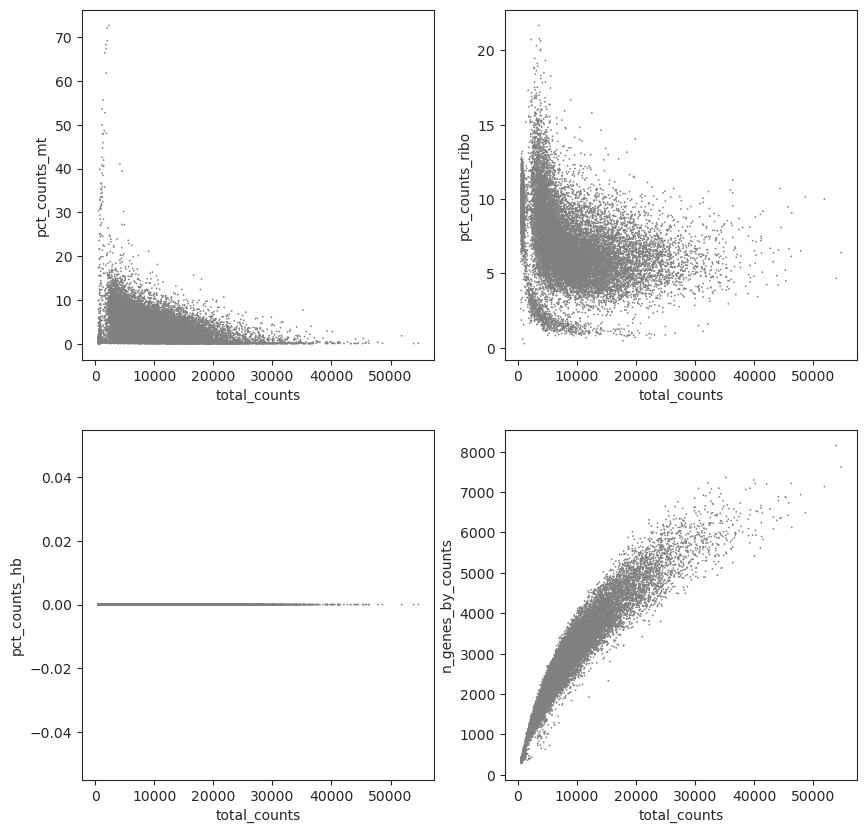

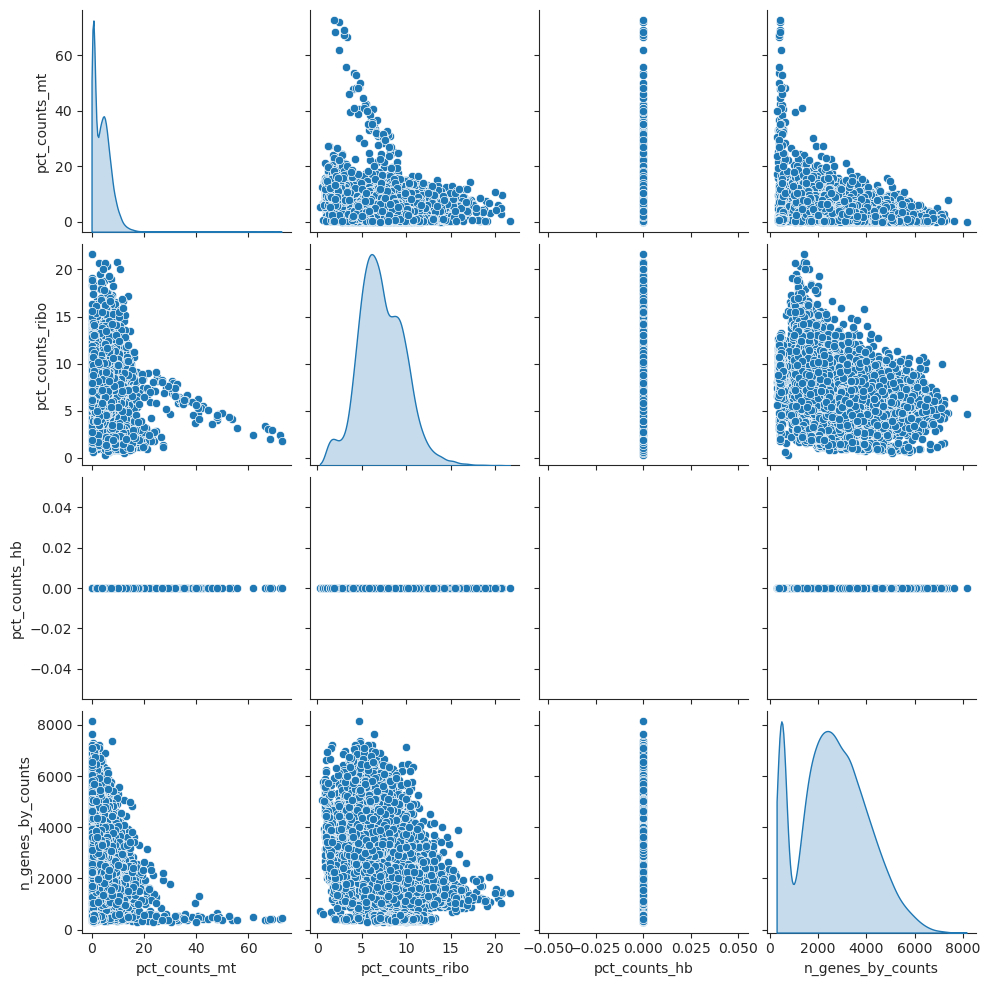

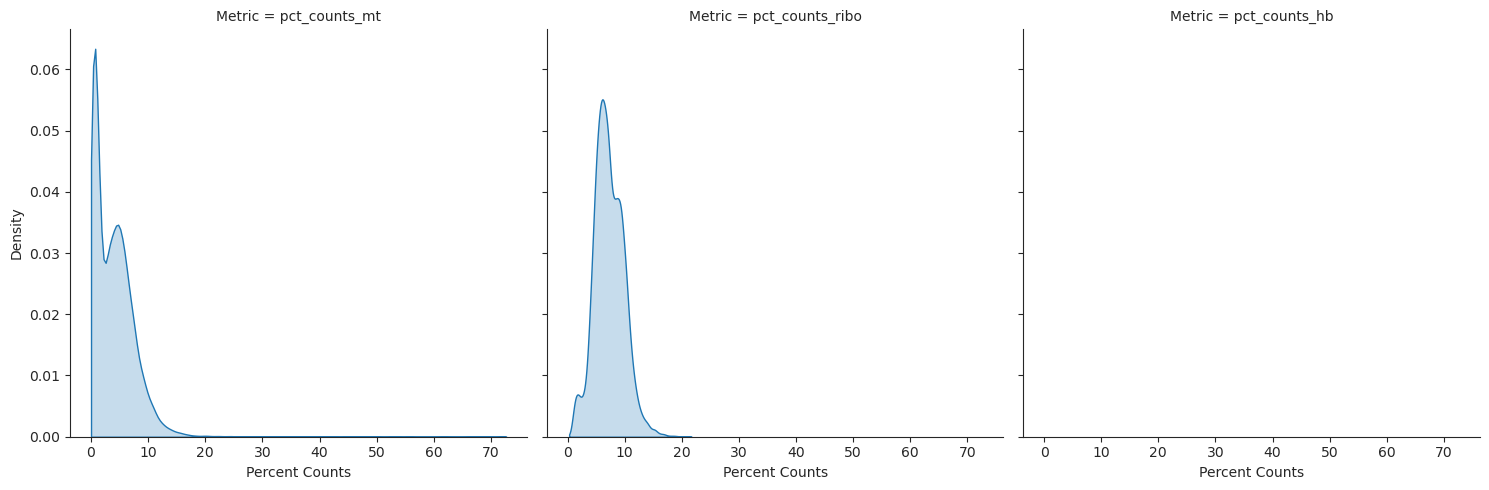

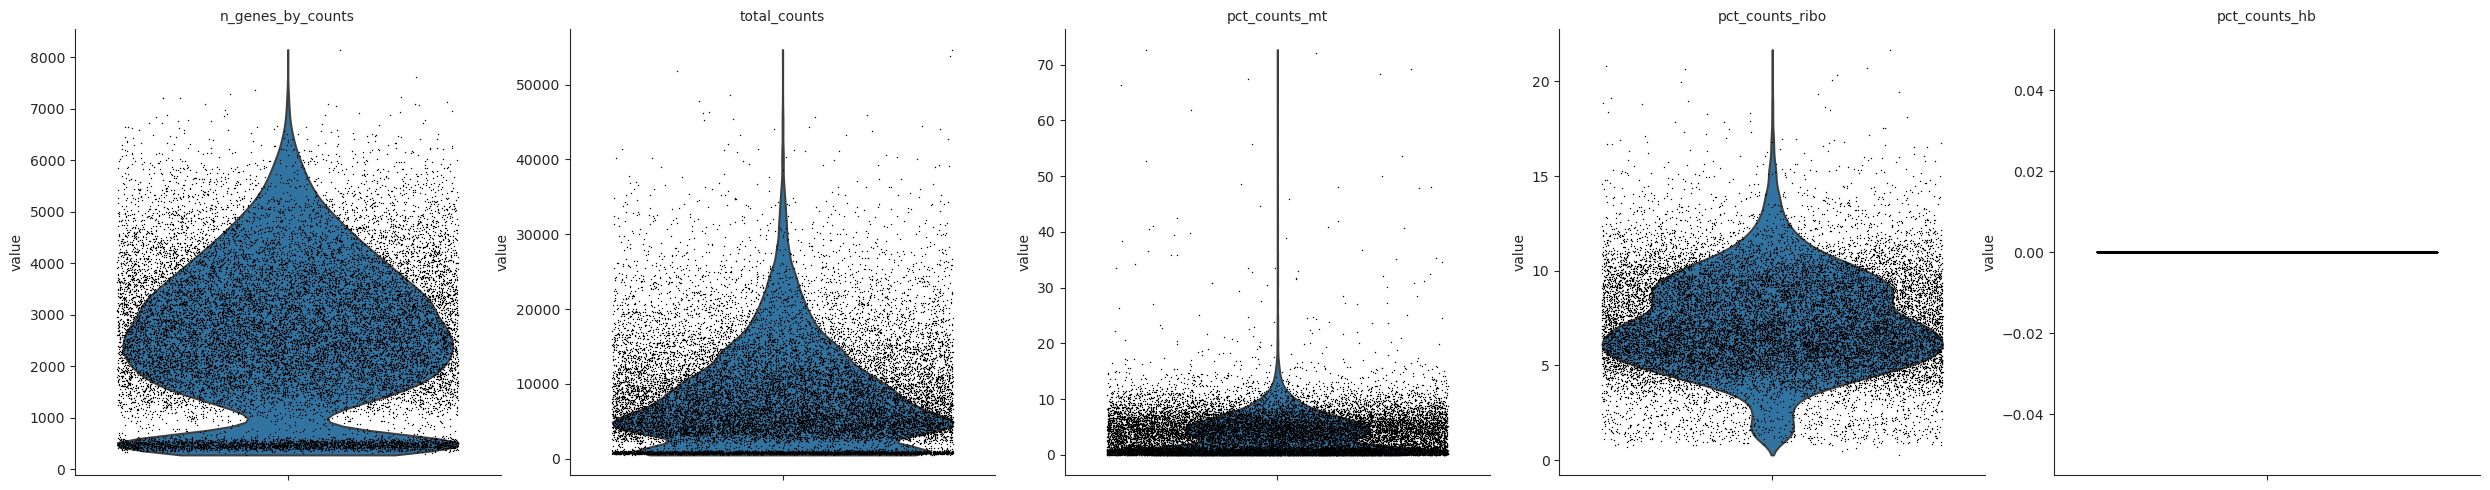

       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count       36601.000000  36601.000000       36601.000000   
mean         1378.291959      0.234447           0.101338   
std          2927.651207      5.301304           0.278060   
min             0.000000      0.000000           0.000000   
25%             0.000000      0.000000           0.000000   
50%            24.000000      0.001248           0.001248   
75%          1125.000000      0.065172           0.063136   
max         19226.000000    803.539062           6.690269   

       pct_dropout_by_counts  total_counts  log1p_total_counts  
count           36601.000000  3.660100e+04        36601.000000  
mean               92.831104  4.507481e+03            3.889242  
std                15.227563  1.019229e+05            3.465176  
min                 0.000000  0.000000e+00            0.000000  
25%                94.148549  0.000000e+00            0.000000  
50%                99.875169  2.400000e+01            3.2188

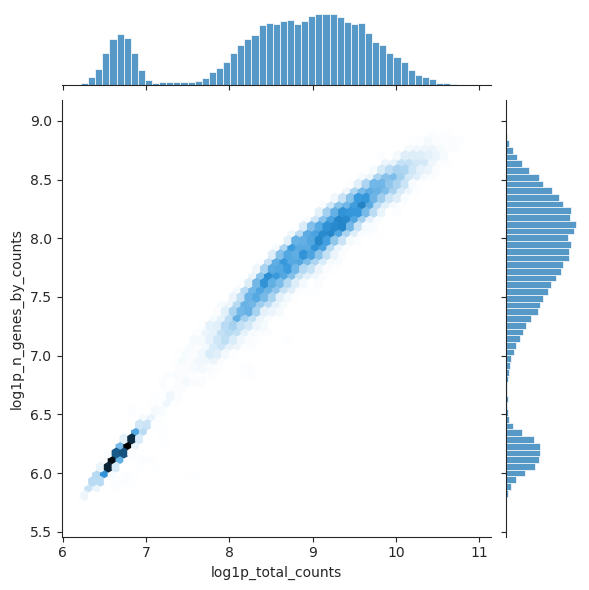

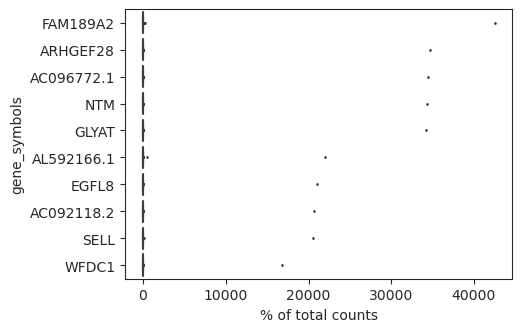


	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




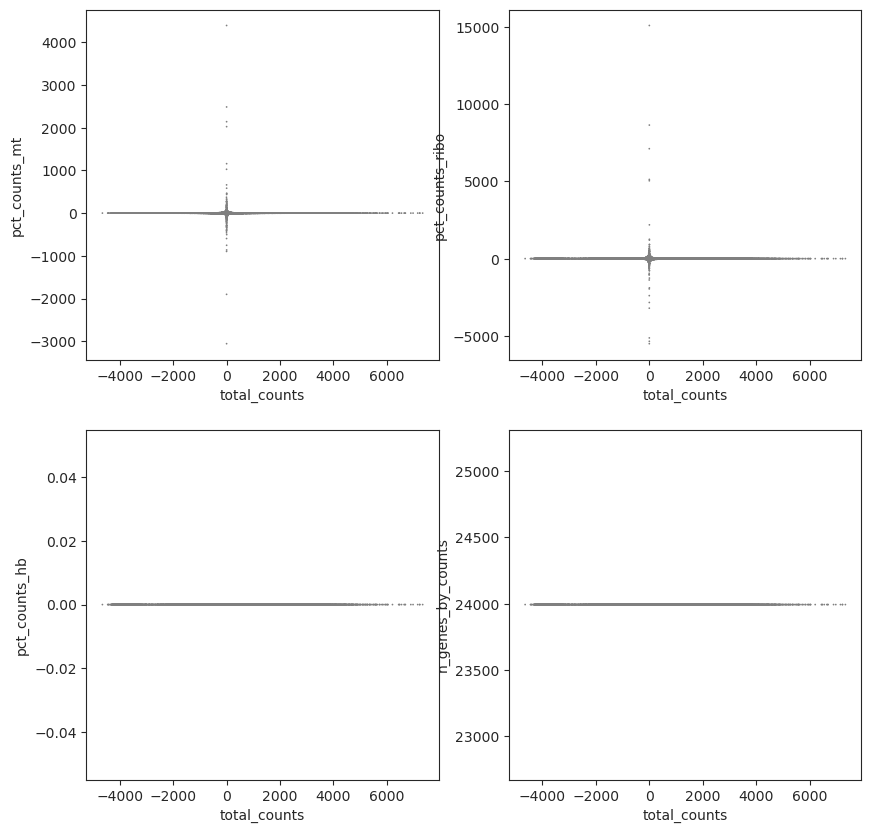

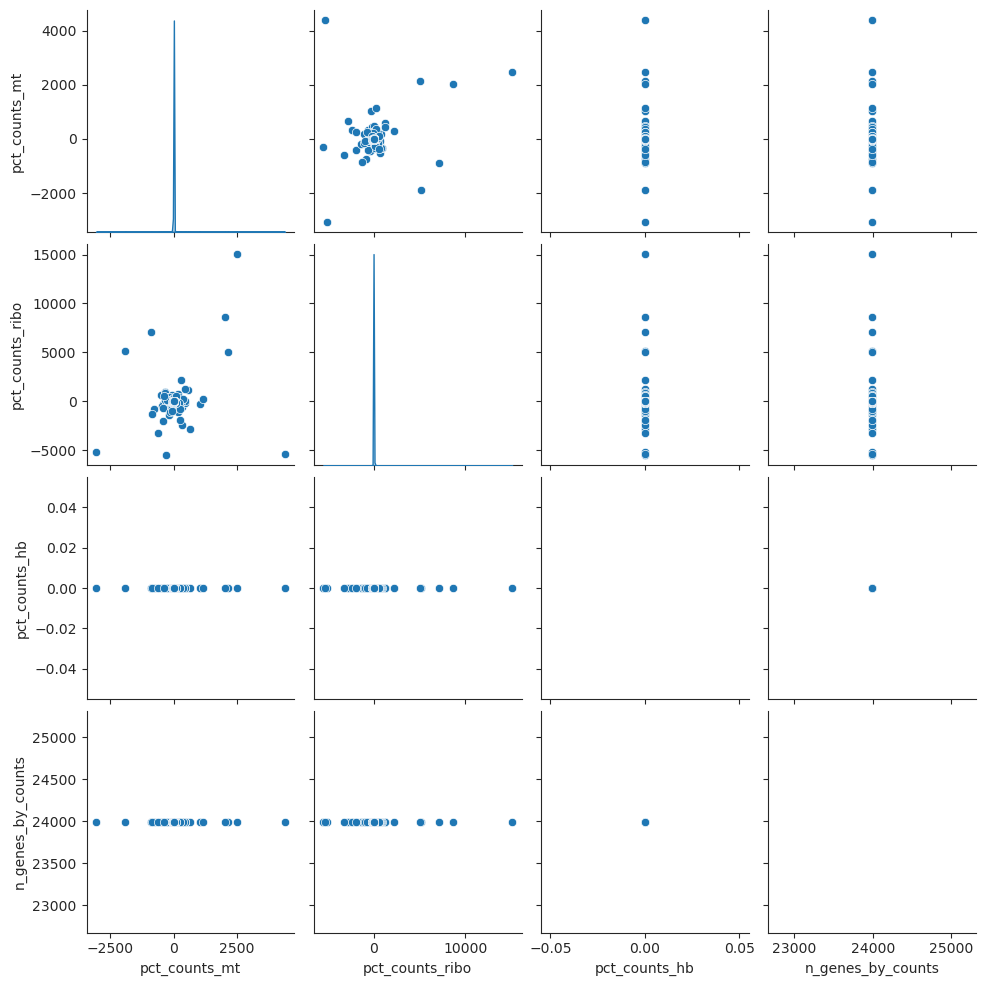

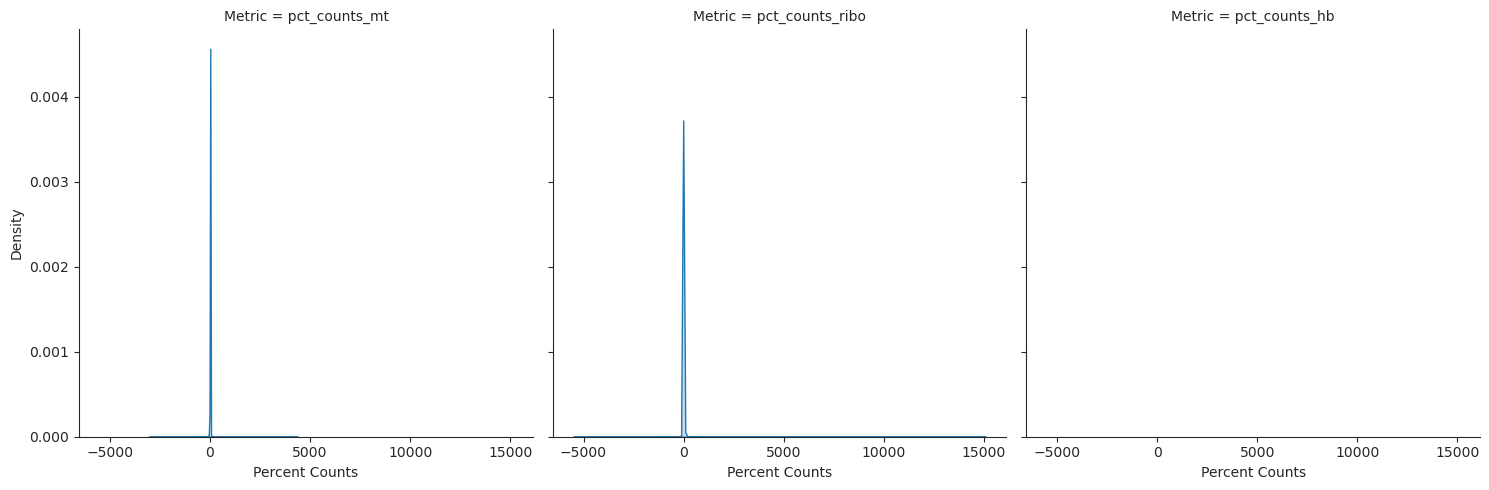

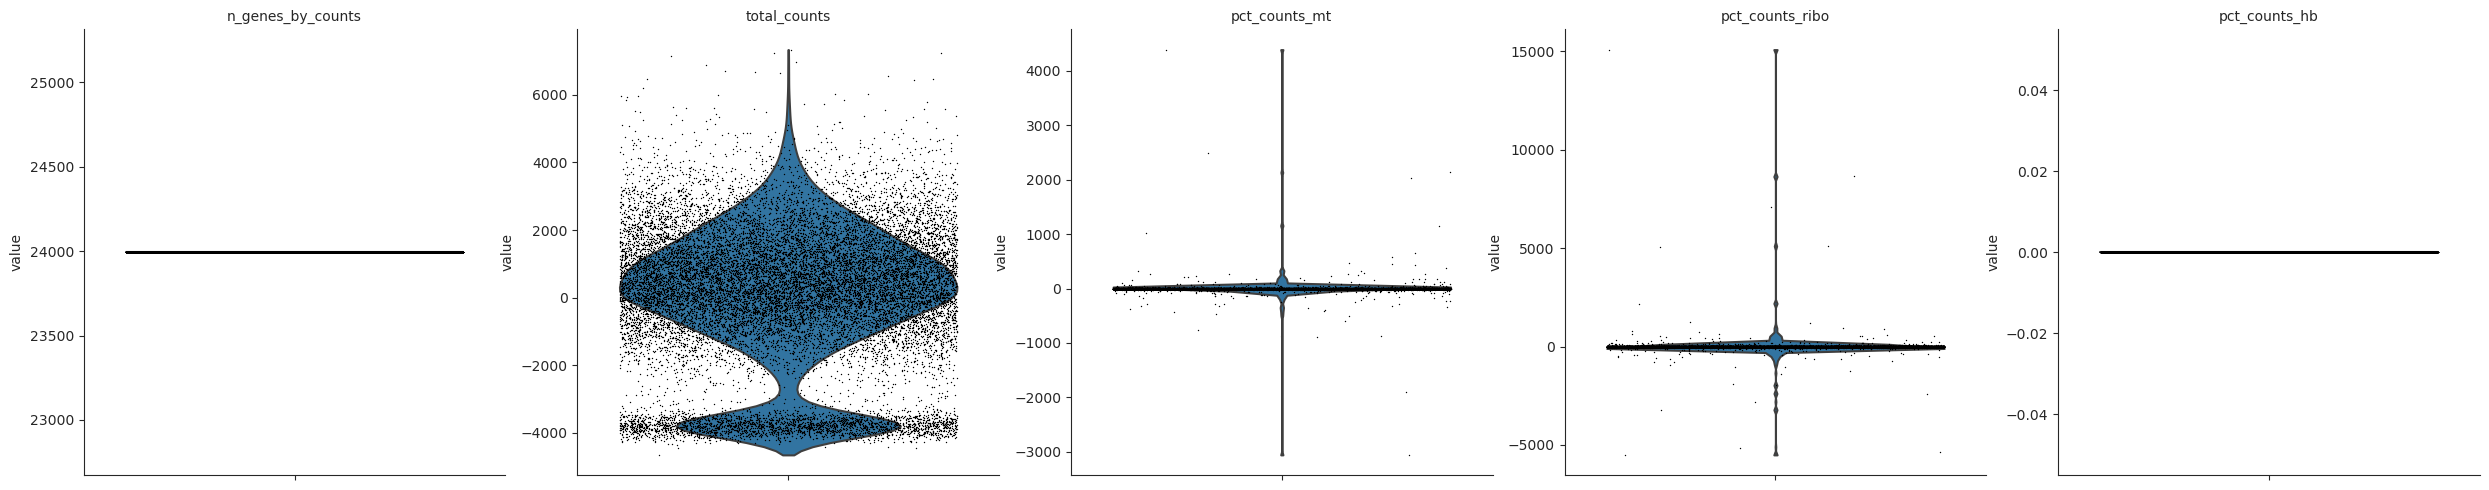

       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count            23993.0  2.399300e+04       2.399300e+04   
mean             19009.0 -3.561244e-09      -3.561436e-09   
std                  0.0  6.214854e-07       6.214854e-07   
min              19009.0 -4.740327e-06      -4.740338e-06   
25%              19009.0 -3.563956e-07      -3.563956e-07   
50%              19009.0 -8.473963e-09      -8.473963e-09   
75%              19009.0  3.505226e-07       3.505225e-07   
max              19009.0  4.003949e-06       4.003941e-06   

       pct_dropout_by_counts  total_counts  log1p_total_counts       n_cells  \
count                23993.0  23993.000000        23993.000000  23993.000000   
mean                     0.0     -0.000068           -0.000138   2084.127370   
std                      0.0      0.011814            0.011822   3371.689809   
min                      0.0     -0.090109           -0.094430      3.000000   
25%                      0.0     -0.006775        

(AnnData object with n_obs × n_vars = 19009 × 23993
     obs: 'num_features', 'feature_call', 'num_umis', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
     var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'log1p', 'hvg'
     layers: 'counts', 'log1p', 'scaled',
 {'qc_metrics': {'highly_expressed_genes': None,
   'qc_n_genes_by_counts_scatter': <Figure size 1000x1000 with 4 Axes>,
   'pairplot': <seaborn.axisgrid.PairGrid at 0x7f706021a290>,
   'pct_counts_kde': <seaborn.axisgrid.FacetGrid at 0x7f70521fb7c0

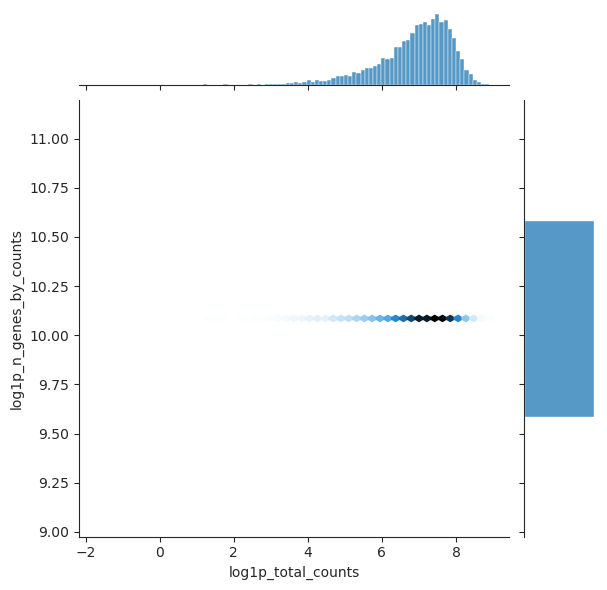

In [3]:
self.preprocess(**kws_pp)

# Clustering

Use this method to perform dimensionality reduction and clustering.

Optionally, by specifying `model_celltypist`, we can also detect cell types using `CellTypist`.

You can provide a CellTypist model name as a string, or to train your own custom model, provide an AnnData object with the training data and, if cell type column names differ across training and main data (in `self`) or if you want to pass additional arguments to `celltypist.train()`, then provide a dictionary of arguments to `kws_train`. (Cell type name can be under `labels` or `col_cell_type` in this dictonary.)

You can see what models are available with this code:
```
import celltypist
celltypist.models.models_description().set_index("model").description.apply(lambda x: print(x))
```

Or it will show you valid models automatically if you feed it an unknown model: `self.cluster(**kws_cluster, model="kate_moss.pkl")``

You can perform this after clustering by leaving `model_celltypist` as None and at any point running `self.annotate_clusters(...)`.

In [6]:
self.rna

AnnData object with n_obs × n_vars = 19009 × 23993
    obs: 'num_features', 'feature_call', 'num_umis', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'log1p', 'scaled'

In [1]:
self.cluster(**kws_cluster)
_ = self.annotate_clusters("COVID19_HumanChallenge_Blood.pkl")

NameError: name 'self' is not defined

# Plots

Create a variety of plots visualizing gene expression, cell clusters, etc.

In [ ]:
clus = list(self.rna.obs["predicted_labels"].sample(2))  # clusters to circle
figs = self.plot(genes=16,  # or could specify list of gene names
                 col_cell_type="predicted_labels",
                 cell_types_circle=clus,  # list cell types to circle on UMAP
                 kws_gex_violin=dict(scale="area", height=10),
                 genes_highlight=None,  # could be genes names to highlight
                 kws_ump=dict(col_cell_type="predicted_labels"))

# Analyses

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs else \
    self._columns["col_cell_type"]
# ccd = self._columns["col_perturbed"]
if self._columns["col_sample_id"] is None:
    self.rna.obs.loc[:, "tmp_sample_id_fake"] = ["1"] * int(
        self.rna.obs.shape[0] / 2) + ["2"] * (self.rna.obs.shape[0] - int(
            self.rna.obs.shape[0] / 2
            ))  # fake sample ID column for demonstration purposes
    csid = "tmp_sample_id_fake"
else:
    csid = self._columns["col_sample_id"]
oca = self.run_composition_analysis(est_fdr=0.05, 
                                    col_sample_id=csid,
                                    col_cell_type=cct,
                                    # col_condition=ccd,
                                    generate_sample_level=True)